# LSI and LDA for search

## The standard IR system as baseline

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import pymongo
from twitter import TwitterDataset, ENTITY, DOMAIN
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation

In [3]:
db = pymongo.MongoClient()['twitter']['tweets']
tdata = TwitterDataset(db)

In [4]:
estats = tdata.entity_queries_stats
dstats = tdata.domain_queries_stats

In [7]:
stopw = set(stopwords.words('english'))
tokenizer = TweetTokenizer()
tokenize = lambda text: [word for word in tokenizer.tokenize(text.lower()) 
                         if word not in punctuation and word not in stopw and not word.startswith('http')] 

### Naive search engine

In [8]:
from search import TfIdfSearchEngine

In [9]:
E = TfIdfSearchEngine(tdata.search_base, tokenize)

In [201]:
query = 'Christmas'
query_text = 'Christmas'
ground_truth = tdata.ground_truth(query, query_type=ENTITY)
ranking = E.search(query_text)

In [202]:
tp, fp, fn, tn = TfIdfSearchEngine.feedback(ranking, 
                                            ground_truth, top_k=4500)

In [203]:
print(len(tp), len(fp), len(fn), len(tn))
print('precision', len(tp) / (len(tp) + len(fp)))
print('recall', len(tp) / (len(tp) + len(fn)))

401 4099 73 17777
precision 0.08911111111111111
recall 0.8459915611814346


In [204]:
ranking_map = dict([(tweet_id, score) for _, tweet_id, score in ranking])
document_ids = [x for x, y in tdata.search_base]
y_true = [1 if x in ground_truth else 0 for x in document_ids]
scores = [ranking_map[x] if x in ranking_map.keys() else 0 for x in document_ids]
y_pred = [1 if ranking_map[x] > 0 else 0 for x in document_ids]

## Evaluate

In [205]:
import matplotlib.pyplot as plt

In [206]:
import sklearn.metrics as mt

In [207]:
precision, recall, thresholds = mt.precision_recall_curve(y_true, scores)
intp = [max(precision[:i+1]) for i in range(len(precision))]

In [208]:
cm = mt.confusion_matrix(y_true, y_pred)
cmd = mt.ConfusionMatrixDisplay(confusion_matrix=cm)

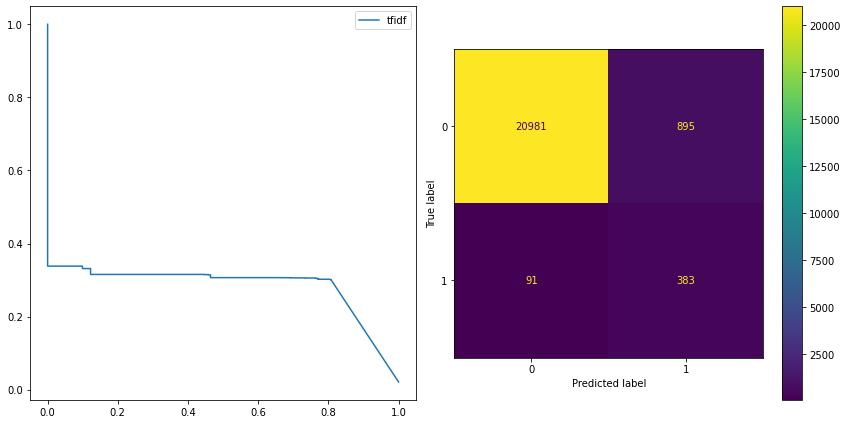

In [209]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].plot(recall, intp, label='tfidf')
cmd.plot(ax=ax[1], values_format='d')
ax[0].legend()
plt.tight_layout()
plt.show()

## Prepare for gensim

In [210]:
from gensim.corpora.textcorpus import TextCorpus
from gensim.corpora import Dictionary

In [211]:
class TweetsCorpus(object):
    def __init__(self, documents):
        self.documents = documents
    def get_texts(self):
        for doc in self.documents:
            yield [word for word in tokenize(doc)]
    def __len__(self):
        return sum(1 for _ in self.get_texts())

In [212]:
tweets_corpus = TweetsCorpus([y for x, y in tdata.search_base])

In [213]:
dictionary = Dictionary(tweets_corpus.get_texts())
corpus = [dictionary.doc2bow(text) for text in tweets_corpus.get_texts()]

## LSI

In [214]:
from gensim.models import LsiModel

In [215]:
model = LsiModel(corpus, id2word=dictionary, num_topics=dstats.shape[0])

In [216]:
vectorized_corpus = model[corpus]

In [217]:
print(len(vectorized_corpus[0]))
print(vectorized_corpus[0][:2])

53
[(0, 0.18828636845352342), (1, 0.3542253523649559)]


### Query to vector

In [218]:
q_vector = model[dictionary.doc2bow(tokenize(query_text))]

In [219]:
q_vector[:2]

[(0, 0.04362150986412014), (1, 0.11279840441864698)]

In [220]:
LSI = np.zeros((len(vectorized_corpus), model.num_topics))
for i, vector in enumerate(vectorized_corpus):
    for topic_id, score in vector:
        LSI[i, topic_id] = score

In [221]:
Q = np.array([y for x, y in q_vector]).reshape(1, -1)

### Match

In [222]:
from sklearn.metrics.pairwise import cosine_similarity

In [223]:
S = cosine_similarity(Q, LSI)

In [224]:
lsi_scores = S[0]
lsi_pred = [1 if x > 0 else 0 for x in lsi_scores]

In [225]:
lsi_precision, lsi_recall, lsi_thresholds = mt.precision_recall_curve(y_true, lsi_scores)
lsi_intp = [max(lsi_precision[:i+1]) for i in range(len(lsi_precision))]

In [226]:
lsi_cm = mt.confusion_matrix(y_true, lsi_pred)
lsi_cmd = mt.ConfusionMatrixDisplay(confusion_matrix=lsi_cm)

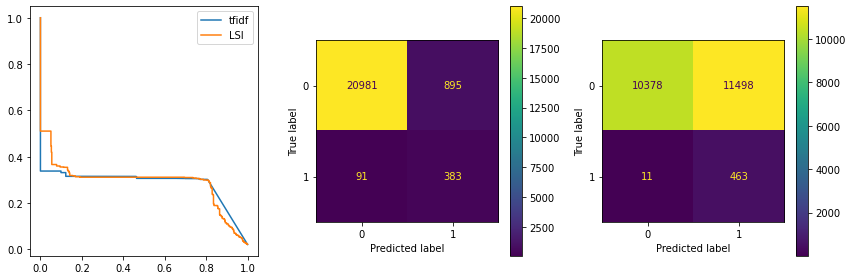

In [227]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].plot(recall, intp, label='tfidf')
ax[0].plot(lsi_recall, lsi_intp, label='LSI')
cmd.plot(ax=ax[1], values_format='d')
lsi_cmd.plot(ax=ax[2], values_format='d')
ax[0].legend()
plt.tight_layout()
plt.show()

## Exercize
- Discuss the different nature of errors from FN to FP
- Try with a domain generic query like `TV Shows`